<a href="https://colab.research.google.com/github/Yhemisol/4B1b/blob/master/ML5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn import datasets, svm
X_digits, y_digits = datasets.load_digits(return_X_y=True)
svc = svm.SVC(C=1, kernel='linear')
svc.fit(X_digits[:-100], y_digits[:-100]).score(X_digits[-100:], y_digits[-100:])

0.98

In [2]:
import numpy as np
X_folds = np.array_split(X_digits, 3)
y_folds = np.array_split(y_digits, 3)
scores = list()
for k in range(3):
    # We use 'list' to copy, in order to 'pop' later on
    X_train = list(X_folds)
    X_test = X_train.pop(k)
    X_train = np.concatenate(X_train)
    y_train = list(y_folds)
    y_test = y_train.pop(k)
    y_train = np.concatenate(y_train)
    scores.append(svc.fit(X_train, y_train).score(X_test, y_test))
print(scores)

[0.9348914858096828, 0.9565943238731218, 0.9398998330550918]


In [3]:
from sklearn.model_selection import KFold, cross_val_score
X = ["a", "a", "a", "b", "b", "c", "c", "c", "c", "c"]
k_fold = KFold(n_splits=5)
for train_indices, test_indices in k_fold.split(X):
     print('Train: %s | test: %s' % (train_indices, test_indices))

Train: [2 3 4 5 6 7 8 9] | test: [0 1]
Train: [0 1 4 5 6 7 8 9] | test: [2 3]
Train: [0 1 2 3 6 7 8 9] | test: [4 5]
Train: [0 1 2 3 4 5 8 9] | test: [6 7]
Train: [0 1 2 3 4 5 6 7] | test: [8 9]


In [4]:
[svc.fit(X_digits[train], y_digits[train]).score(X_digits[test], y_digits[test])
 for train, test in k_fold.split(X_digits)]

[0.9638888888888889,
 0.9222222222222223,
 0.9637883008356546,
 0.9637883008356546,
 0.9303621169916435]

In [5]:
cross_val_score(svc, X_digits, y_digits, cv=k_fold, n_jobs=-1)

array([0.96388889, 0.92222222, 0.9637883 , 0.9637883 , 0.93036212])

In [6]:
cross_val_score(svc, X_digits, y_digits, cv=k_fold,
                scoring='precision_macro')

array([0.96578289, 0.92708922, 0.96681476, 0.96362897, 0.93192644])

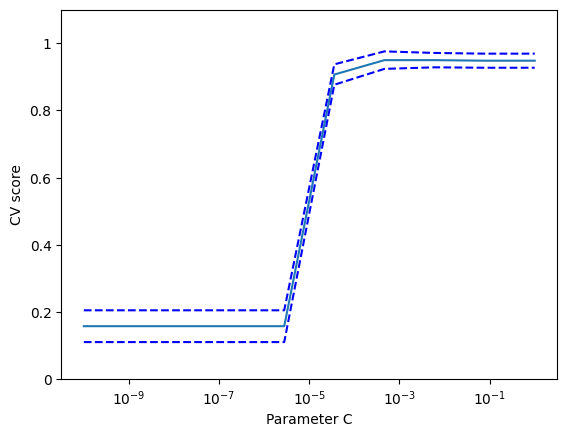

In [7]:
import numpy as np
from sklearn import datasets, svm
from sklearn.model_selection import cross_val_score
X, y = datasets.load_digits(return_X_y=True)
svc = svm.SVC(kernel="linear")
C_s = np.logspace(-10, 0, 10)
scores = list()
scores_std = list()
for C in C_s:
    svc.C = C
    this_scores = cross_val_score(svc, X, y, n_jobs=1)
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))

import matplotlib.pyplot as plt

plt.figure()
plt.semilogx(C_s, scores)
plt.semilogx(C_s, np.array(scores) + np.array(scores_std), "b--")
plt.semilogx(C_s, np.array(scores) - np.array(scores_std), "b--")
locs, labels = plt.yticks()
plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.ylabel("CV score")
plt.xlabel("Parameter C")
plt.ylim(0, 1.1)
plt.show()

In [8]:
#Grid-search and cross-validated estimators
from sklearn.model_selection import GridSearchCV, cross_val_score
Cs = np.logspace(-6, -1, 10)
clf = GridSearchCV(estimator=svc, param_grid=dict(C=Cs),
                   n_jobs=-1)
clf.fit(X_digits[:1000], y_digits[:1000])
clf.best_score_
clf.best_estimator_.C

# Prediction performance on test set is not as good as on train set
clf.score(X_digits[1000:], y_digits[1000:])

0.946047678795483

In [9]:
#Nested cross-validation
cross_val_score(clf, X_digits, y_digits)

array([0.94722222, 0.91666667, 0.96657382, 0.97493036, 0.93593315])

In [10]:
#Cross-validated estimators
from sklearn import linear_model, datasets
lasso = linear_model.LassoCV()
X_diabetes, y_diabetes = datasets.load_diabetes(return_X_y=True)
lasso.fit(X_diabetes, y_diabetes)
# The estimator chose automatically its lambda:
lasso.alpha_

0.00375376715269185

In [11]:
#Cross-validation on diabetes Dataset Exercise
import matplotlib.pyplot as plt
import numpy as np

from sklearn import datasets
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

X, y = datasets.load_diabetes(return_X_y=True)
X = X[:150]
y = y[:150]

lasso = Lasso(random_state=0, max_iter=10000)
alphas = np.logspace(-4, -0.5, 30)

tuned_parameters = [{"alpha": alphas}]
n_folds = 5

clf = GridSearchCV(lasso, tuned_parameters, cv=n_folds, refit=False)
clf.fit(X, y)
scores = clf.cv_results_["mean_test_score"]
scores_std = clf.cv_results_["std_test_score"]

(0.0001, 0.31622776601683794)

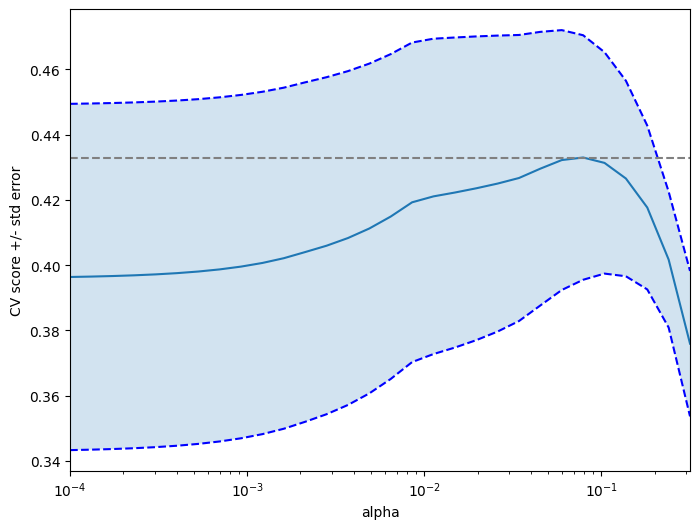

In [12]:
#Plot error lines showing +/- std. errors of the scores
plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)

std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, "b--")
plt.semilogx(alphas, scores - std_error, "b--")

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel("CV score +/- std error")
plt.xlabel("alpha")
plt.axhline(np.max(scores), linestyle="--", color=".5")
plt.xlim([alphas[0], alphas[-1]])

In [13]:
#How much can you trust the selection of alpha?
# To answer this question we use the LassoCV object that sets its alpha
# parameter automatically from the data by internal cross-validation (i.e. it
# performs cross-validation on the training data it receives).
# We use external cross-validation to see how much the automatically obtained
# alphas differ across different cross-validation folds.

from sklearn.linear_model import LassoCV
from sklearn.model_selection import KFold

lasso_cv = LassoCV(alphas=alphas, random_state=0, max_iter=10000)
k_fold = KFold(3)

print("Answer to the bonus question:", "how much can you trust the selection of alpha?")
print()
print("Alpha parameters maximising the generalization score on different")
print("subsets of the data:")
for k, (train, test) in enumerate(k_fold.split(X, y)):
    lasso_cv.fit(X[train], y[train])
    print(
        "[fold {0}] alpha: {1:.5f}, score: {2:.5f}".format(
            k, lasso_cv.alpha_, lasso_cv.score(X[test], y[test])
        )
    )
print()
print("Answer: Not very much since we obtained different alphas for different")
print("subsets of the data and moreover, the scores for these alphas differ")
print("quite substantially.")

plt.show()

Answer to the bonus question: how much can you trust the selection of alpha?

Alpha parameters maximising the generalization score on different
subsets of the data:
[fold 0] alpha: 0.05968, score: 0.54209
[fold 1] alpha: 0.04520, score: 0.15521
[fold 2] alpha: 0.07880, score: 0.45192

Answer: Not very much since we obtained different alphas for different
subsets of the data and moreover, the scores for these alphas differ
quite substantially.
